# TRANSFER LEARNING

**_Experimenting with Transfer Learning for a classification task._**

In transfer learning, features learned on one problem are taken and leveraged them on a new and similar problem. It is usually done for tasks where dataset has too little to train a full-scale model from scratch. 

**The Experiment:**

- Loads _MobileNetV2_ model - pretrained on _imagenet_ dataset, as a base model taking all layers except the top one that is used for classification specific to ImageNet task.

- Freezes all the layers in the base model to avoid destroying already learned parameters during training related to new task to classify cats and dogs.

- Adds few new, trainable layers such as pooling, dropout and dense layer on top of the frozen layers for them to learn based on the new dataset.

- Prepares the new dataset in a form that is acceptable by the base model.

- Trains the head (newly added layers) on the new data over few epochs to get them trained.

- Unfreezes the all the layers in the base model and fine-tunes the entire model by re-training it on the new data with a very low learning rate to achieve meaningful improvements by incrementally adapting the pretrained features to the new data.

- Evaluates the model performance on the test data.

## Importing Packages

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import data as tf_data

import matplotlib.pyplot as plt

2025-12-01 07:53:52.089555: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-01 07:53:52.089866: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 07:53:52.141210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 07:53:53.446230: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## Data Ingestion

In [2]:
# Fetches the "cats vs. dogs" dataset using TFDS
# Only 40% of the data is used to show the effectiveness of transfer learning
train_set, val_set, test_set = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],  # 40% for training, 10% for validation and 10% for test
    as_supervised=True,                                         # Includes labels
)

print("Sample Counts:")
print(f"Training: {train_set.cardinality()}, Validation: {val_set.cardinality()}, Test: {test_set.cardinality()}")

Sample Counts:
Training: 9305, Validation: 2326, Test: 2326


2025-12-01 07:53:55.333703: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Data Analysis

2025-12-01 07:53:55.626855: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-12-01 07:53:55.678702: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


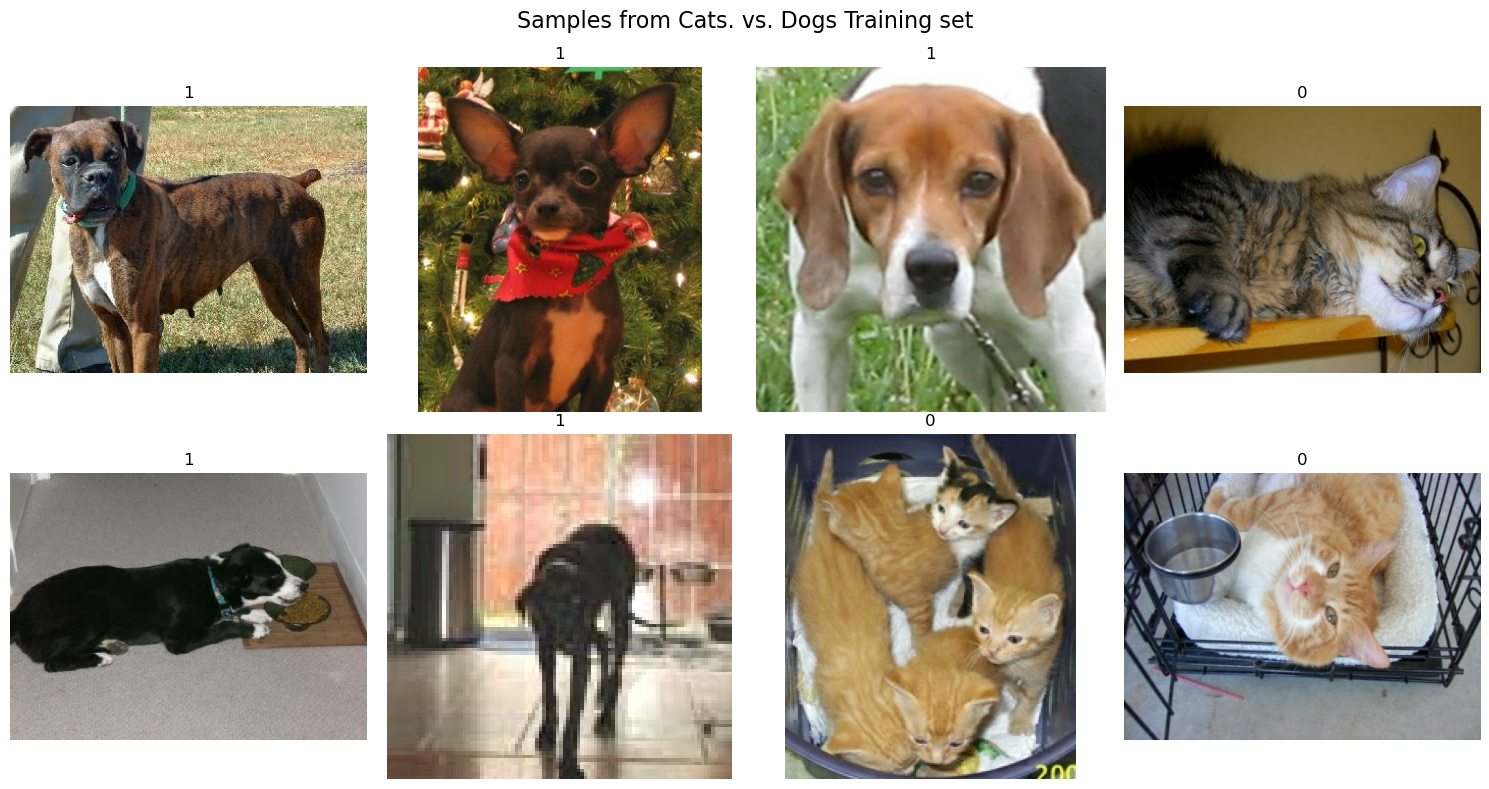

In [3]:
# Plots few of the samples from the train set

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flatten()                                       # Flattens 2D array of axes to 1D for easier iteration
for idx, (image, label) in enumerate(train_set.take(8)):    # Iterates through sample images to plot them
    axes[idx].imshow(image)                                 # Displays image in corresponding subplot
    axes[idx].set_title(int(label))                         # Sets title of subplot to image label
    axes[idx].axis("off")                                   # Hides axis for a cleaner look

plt.suptitle("Samples from Cats. vs. Dogs Training set", fontsize=16)   # Sets figure title
plt.tight_layout()                                          # Adjusts layout to prevent overlap
plt.show()

## Data Preprocessing

As the images size varies and each pixel consists of 3 integer values between 0 and 255 (RGB level values), all the images get resized to same size of 160x160 and pixel values get normalized between -1 and 1 according to the requirement of the pretrained model. Additionally, random data augmentation is also applied.

**Resizing images**

In [4]:
resizer = tf.keras.layers.Resizing(160, 160)            # Uses layer as a utulity function

# Maps each sample from the each of the datasets and performs resizing

train_set = train_set.map(lambda x, y: (resizer(x), y))
val_set = val_set.map(lambda x, y: (resizer(x), y))
test_set = test_set.map(lambda x, y: (resizer(x), y))


In [5]:
# Confirms the resizing just by taking one sample with an index
next(iter(train_set))[0].shape

TensorShape([160, 160, 3])

**Augmenting Data**

Applying data augmentation to generate samples artificially by applying random and realistic transformations to the training images, such as random horizontal flipping or small random rotations helping the model to get exposed to different aspects of the training data while slowing down overfitting. It makes sense when dataset is not large or not balanced.

In [6]:
# Configures the sequence of operations (once again taking layers as utulity functions)
augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
]

def data_augmentation(x):
    """
    Augments the image by flipping and rotating it
    """
    for layer in augmentation_layers:
        x = layer(x)
    return x

train_set = train_set.map(lambda x, y: (data_augmentation(x), y))   # Augments only train set and the on validation and test set are not generally done


**Batching Data and Optimizing Loading Speed using Prefetching and Caching**

In [7]:
batch_size = 32

train_set = train_set.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
val_set = val_set.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_set = test_set.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

## Modeling

In [8]:
# Instantiates the MobileNetV2 as base model architecture

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(160, 160, 3),
    include_top=False,          # Excludes imagenet specific top layer
    weights="imagenet",         # Loads weights of model pretrained on "imagenet" dataset
)

base_model.trainable=False      # Freezes all layers in the base model

In [9]:
# Creates model out of base model

inputs = tf.keras.layers.Input(shape=(160, 160, 3))             # Defines the model input with shape expectation
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs) # Scales input pixels between -1 and 1 before passing them to the model.
x = base_model(x, training=False)                               # Sets base_model in inference mode here
x = tf.keras.layers.GlobalAveragePooling2D()(x)                 # Converts base model's multi-dimensional output (`base_model.output_shape[1:]`) to vectors
x = tf.keras.layers.Dropout(0.2)(x)                             # Regularizes with dropout
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)     # Creates target model combining inputs and outputs

In [10]:
model.summary(show_trainable=True)      # Shows the model summary with both trainable and non-trainable parameters

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 160, 160, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide (TrueDivide)    │ (None, 160, 160, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract (Subtract)         │ (None, 160, 160, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_160        │ (None, 5, 5, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1)             │      1,281 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training the Model

### Training Head of the Model

In [ ]:
# Compiles the model with "adam" optimizer, tf.keras.losses.BinaryCrossentropy(from_logits=True) as loss,
# [tf.keras.metrics.BinaryAccuracy()] as metrics
model.compile(optimizer="adam", 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # `from_logits` is set to True when final layer does not have a sigmoid activation
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Fits the model on train set with 2 epochs and measures the learning over validation set
model.fit(train_set, epochs=2, validation_data=val_set)

Epoch 1/2


291/291 ━━━━━━━━━━━━━━━━━━━━ 66s 213ms/step - binary_accuracy: 0.9262 - loss: 0.1616 - val_binary_accuracy: 0.9764 - val_loss: 0.0682
Epoch 2/2
291/291 ━━━━━━━━━━━━━━━━━━━━ 46s 160ms/step - binary_accuracy: 0.9649 - loss: 0.0849 - val_binary_accuracy: 0.9798 - val_loss: 0.0590


In [ ]:
# Evaluates the model performance post head training

post_head_train_perf = model.evaluate(test_set)

print(f"Test set performance after head training:\n \
      Loss: {post_head_train_perf[0]:.2f}, Accuracy: {post_head_train_perf[1] * 100:.2f}%")

73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - binary_accuracy: 0.9781 - loss: 0.0659
Test set performance after head training:
       Loss: 0.07, Accuracy: 97.81%


### Fine-tuning the Model
Unfreezing the base model and training the entire model end-to-end with a low learning rate.

In [13]:
base_model.trainable = True     # Sets back base model in training mode

model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 160, 160, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide (TrueDivide)    │ (None, 160, 160, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract (Subtract)         │ (None, 160, 160, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_160        │ (None, 5, 5, 1280)    │  2,257,984 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1)             │      1,281 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 2,225,153 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 2,564 (10.02 KB)

In [ ]:
# Compiles the model with tf.keras.optimizers.Adam(1e-5) optimizer, 
# tf.keras.losses.BinaryCrossentropy(from_logits=True) as loss, and
# [tf.keras.metrics.BinaryAccuracy()] as metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Sets a very low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

# Fits the model to fine-tune in train set with 5 epochs and measures the improvement over validation set
model.fit(train_set, epochs=5, validation_data=val_set)

291/291 ━━━━━━━━━━━━━━━━━━━━ 223s 695ms/step - binary_accuracy: 0.9149 - loss: 0.2332 - val_binary_accuracy: 0.9733 - val_loss: 0.0848


In [ ]:
# Evaluates the model performance post fine-tuning the full model

post_full_model_train_perf = model.evaluate(test_set)

print(f"Test set performance after full model training:\n \
      Loss: {post_full_model_train_perf[0]:.2f}, Accuracy: {post_full_model_train_perf[1] * 100:.2f}%")

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - binary_accuracy: 0.9798 - loss: 0.0661
Test set performance after full model training:
       Loss: 0.07, Accuracy: 97.98%


## Observations:

- Using only 40% of the training data, the fine-tuned model achieve decent accuracy using tranfer learning.

- Data augmentation was applied to avoid or reduce model overfitting.

- Pretrained model was used to show the possibility of building decent model when data is not sufficient to build model from scratch.

- General workflow of transfer learning such as head training and full model fine-tuning was followed to build the model successfully.